<a href="https://colab.research.google.com/github/aliasgharchakera/GPU-Spring24-Assignment01/blob/main/AY06993_Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 432 GPU Accelerated Programming
## Assignment 1
### Ali Asghar Yousuf
### ay06993@st.habib.edu.pk

### Initialization

In [13]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-83ek9w2c
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-83ek9w2c
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [14]:
!nvidia-smi

Mon Jan 29 11:55:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Part I: Memory Initialization and Copying

In [15]:
%%cuda
#include <stdio.h>
#include <curand_kernel.h>
#include <time.h>

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

__global__ void InitData(int* data, const int N)
{
    curandState_t state;
    curand_init(clock64(), 0, 0, &state);
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < N) {
        data[idx] = curand(&state) % 100;
    }
}

int main()
{
  int* h_data = 0;
  int* d_data = 0;
  clock_t start = 0;

  const int sizes[] = {1000, 10000, 100000, 1000000};
  const int numSizes = 4;
  double cpuTimes[numSizes];
  double gpuTimes[numSizes];
  double copyTimes[numSizes];

  //allocate memory on device
  cudaMalloc((void **)&d_data, 10*sizeof(int));

  InitData<<<1, 10>>>(d_data, 10);
  checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
  cudaFree(d_data);
  // Open a file for writing
  FILE *f = fopen("init_timings.txt", "w");
  if (f == NULL) {
      printf("Error opening file!\n");
      return 1;
  }

  // Different execution configurations
  const int threadConfigs[] = {32, 64, 128, 256, 512};
  const int numConfigs = 5;

  for (int c = 0; c < numConfigs; ++c) {
    int numThreadsPerBlock = threadConfigs[c];

    for (int s = 0; s < numSizes; ++s) {
      const int N = sizes[s];
      int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
      size_t size = N * sizeof(int);

      h_data = (int*)malloc(size);
      //calculate on host
      start = clock();
      for (int i = 0; i < N; i++) {
          h_data[i] = rand() % 100;
      }
      cpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //allocate memory on device
      cudaMalloc((void **)&d_data, size);

      //calculate on device
      start = clock();
      InitData<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_data, N);
      checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
      gpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //copy device data to host memory
      start = clock();
      checkCudaErr(cudaMemcpy(h_data, d_data, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
      copyTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //release memory
      cudaFree(d_data);
      free(h_data);

      // Write to file
      fprintf(f, "%d\t%d\t%d\t%f\t%f\t%f\n", N, numThreadsPerBlock, numBlocksPerGrid, cpuTimes[s], gpuTimes[s], copyTimes[s]);
    }
  }

  fclose(f);

  return 0;
}

#### Plotting the results of Part I for different execution configurations

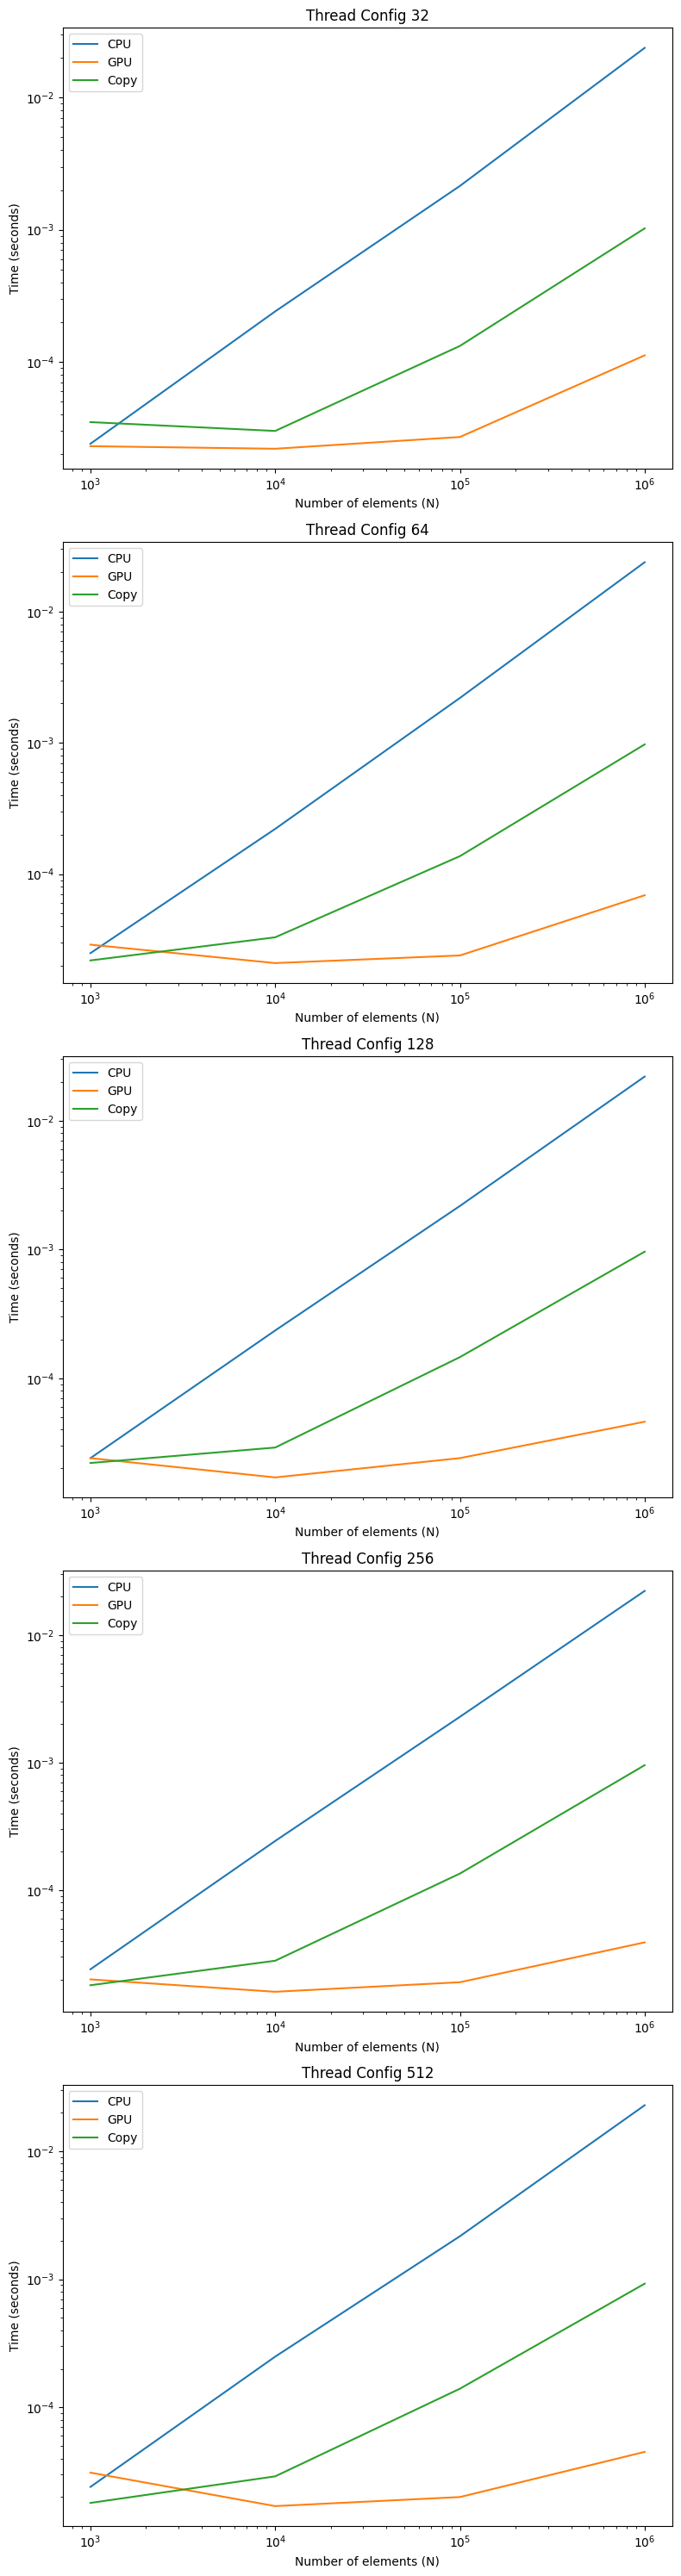

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Read the timing results from the file
with open('init_timings.txt') as f:
    data = f.readlines()

# Parse the data
sizes = []
thread_configs = []
num_blocks_per_grids = []
cpu_times = []
gpu_times = []
copy_times = []
for line in data:
    line = line.strip()
    values = line.split('\t')
    sizes.append(int(values[0]))
    thread_configs.append(int(values[1]))
    num_blocks_per_grids.append(int(values[2]))
    cpu_times.append(float(values[3]))
    gpu_times.append(float(values[4]))
    copy_times.append(float(values[5]))

# Create a color map for different thread configs
color_map = plt.get_cmap('tab10')

# Get unique thread configs
unique_thread_configs = (list(set(thread_configs)))
unique_thread_configs.sort()

# Create subplots for each thread config
fig, axs = plt.subplots(len(unique_thread_configs), 1, figsize=(8, 6 * len(unique_thread_configs)))

# Plot for each thread config
for i, config in enumerate(unique_thread_configs):
    indices = [j for j, x in enumerate(thread_configs) if x == config]
    ax = axs[i]
    ax.plot(np.array(sizes)[indices], np.array(cpu_times)[indices], label='CPU', color=color_map(0))
    ax.plot(np.array(sizes)[indices], np.array(gpu_times)[indices], label='GPU', color=color_map(1))
    ax.plot(np.array(sizes)[indices], np.array(copy_times)[indices], label='Copy', color=color_map(2))
    ax.set_xlabel('Number of elements (N)')
    ax.set_ylabel('Time (seconds)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Thread Config {config}')
    ax.legend(loc='upper left')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


As visible from the graph, we see that data initialization on the CPU is linear, whereas on the GPU it is almost constant (for the values of N that we have tested). This is because the GPU is able to initialize the data in parallel, whereas the CPU does it sequentially.

Another interesting observation is that the time taken to copy the data from the GPU to the CPU is much higher than the time required to initialize the data on the GPU. This is because the GPU has to copy the data from its memory to the CPU's memory which is bottlenecked by the speed of the PCI-E bus, which is much slower than the speed of the GPU's memory, as we discussed in class.

### Part II: Calculation

In [17]:
%%cuda
#include <stdio.h>
#include <time.h>

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

__global__ void SumDevice(int* a, int* b, int* c, const int N) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    if (i<N) {
        c[i] = a[i] + b[i];
    }
}

void SumHost(int* a, int* b, int* c, const int N) {
    for (int i = 0; i < N; ++i) {
        c[i] = a[i] + b[i];
    }
}

int main() {
    int* h_a = 0;
    int* h_b = 0;
    int* h_c = 0;

    int* d_a = 0;
    int* d_b = 0;
    int* d_c = 0;

    const int sizes[] = {1000, 10000, 100000, 1000000};
    const int numSizes = 4;
    double cpuTimes[numSizes];
    double gpuTimes[numSizes];
		double copyTimes[numSizes];

		//Get the gpu up and running, since the first call usually takes some overhead time to start
		//allocate device memory
		cudaMalloc((void**)&d_a, 10*sizeof(int));
		cudaMalloc((void**)&d_b, 10*sizeof(int));
		cudaMalloc((void**)&d_c, 10*sizeof(int));
		//calculate on device
		SumDevice<<<1, 10>>>(d_a, d_b, d_c, 10);
		checkCudaErr(cudaDeviceSynchronize(), "Syncronization");

		//delete data allocated on device
		cudaFree(d_a);
		cudaFree(d_b);
		cudaFree(d_c);

		// Open a file for writing
    FILE *f = fopen("sum_timings.txt", "w");
    if (f == NULL) {
        printf("Error opening file!\n");
        return 1;
    }

		// Different execution configurations
    const int threadConfigs[] = {32, 64, 128, 256, 512};
    const int numConfigs = 5;

		for (int c = 0; c < numConfigs; ++c) {
      int numThreadsPerBlock = threadConfigs[c];

			for (int s = 0; s < numSizes; ++s) {
				const int N = sizes[s];
				int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
				size_t size = N * sizeof(int);

				//allocate host memory
				h_a = (int*)malloc(size);
				h_b = (int*)malloc(size);
				h_c = (int*)malloc(size);

				//allocate device memory
				cudaMalloc((void**)&d_a, size);
				cudaMalloc((void**)&d_b, size);
				cudaMalloc((void**)&d_c, size);

				//calculate on host
				clock_t start = clock();
				SumHost(h_a, h_b, h_c, N);
				cpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//calculate on device
				start = clock();
				SumDevice<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_a, d_b, d_c, N);
				checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
				gpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//copy result from device to host
				start = clock();
				checkCudaErr(cudaMemcpy(h_a, d_a, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
				checkCudaErr(cudaMemcpy(h_b, d_b, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
				checkCudaErr(cudaMemcpy(h_c, d_c, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
				copyTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//delete data allocated on device
				cudaFree(d_a);
				cudaFree(d_b);
				cudaFree(d_c);

				//delete host memory
				free(h_a);
				free(h_b);
				free(h_c);

				// Write the results to the file
				fprintf(f, "%d\t%d\t%d\t%f\t%f\t%f\n", N, numThreadsPerBlock, numBlocksPerGrid, cpuTimes[s], gpuTimes[s], copyTimes[s]);
			}
		}

    // Close the file
    fclose(f);
    return 0;
}


#### Plotting the results of Part II for different execution configurations

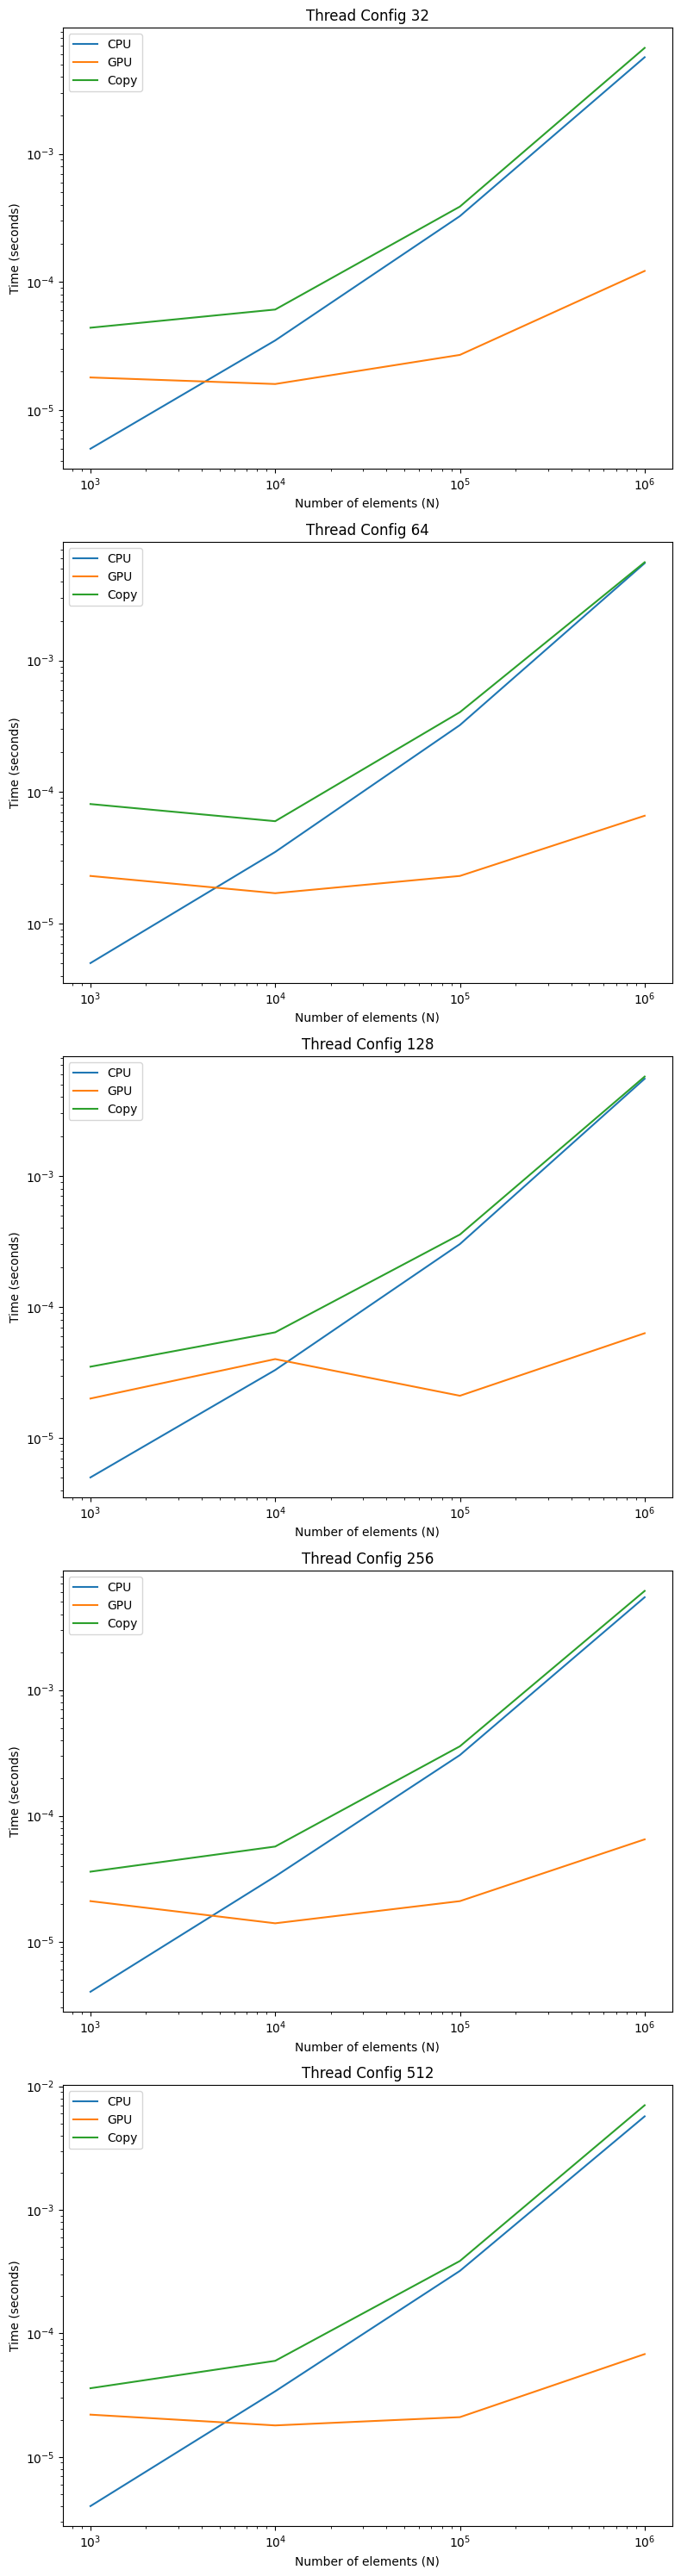

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Read the timing results from the file
with open('sum_timings.txt') as f:
    data = f.readlines()

# Parse the data
sizes = []
thread_configs = []
num_blocks_per_grids = []
cpu_times = []
gpu_times = []
copy_times = []
for line in data:
    line = line.strip()
    values = line.split('\t')
    sizes.append(int(values[0]))
    thread_configs.append(int(values[1]))
    num_blocks_per_grids.append(int(values[2]))
    cpu_times.append(float(values[3]))
    gpu_times.append(float(values[4]))
    copy_times.append(float(values[5]))

# Create a color map for different thread configs
color_map = plt.get_cmap('tab10')

# Get unique thread configs
unique_thread_configs = (list(set(thread_configs)))
unique_thread_configs.sort()

# Create subplots for each thread config
fig, axs = plt.subplots(len(unique_thread_configs), 1, figsize=(8, 6 * len(unique_thread_configs)))

# Plot for each thread config
for i, config in enumerate(unique_thread_configs):
    indices = [j for j, x in enumerate(thread_configs) if x == config]
    ax = axs[i]
    ax.plot(np.array(sizes)[indices], np.array(cpu_times)[indices], label='CPU', color=color_map(0))
    ax.plot(np.array(sizes)[indices], np.array(gpu_times)[indices], label='GPU', color=color_map(1))
    ax.plot(np.array(sizes)[indices], np.array(copy_times)[indices], label='Copy', color=color_map(2))
    ax.set_xlabel('Number of elements (N)')
    ax.set_ylabel('Time (seconds)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Thread Config {config}')
    ax.legend(loc='upper left')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Once again we see a very linear trend for the CPU, whereas the GPU curve grows very slowly. While the GPU takes higher time for smaller values of N, it quickly overtakes the CPU and becomes much faster as N grows larger. This is because the GPU is able to perform the calculations in parallel, whereas the CPU does it sequentially. Similar to Part I, we see that the time taken to copy the data from the GPU to the CPU is much higher than the time required to perform the calculations on the GPU due to the interface bottleneck.

### References

1. [Error Catching](https://github.com/mmmovania/CUDA_Spring_2024/blob/main/Week2/InitDataOnGPU.ipynb)
2. [Timing](https://github.com/mmmovania/CUDA_Spring_2024/blob/main/Week3/Calculate_SumOnGPU_Timed.ipynb)
3. [CuRAND](https://docs.nvidia.com/cuda/curand/index.html)
4. [ILE C/C++ Runtime Library Functions](https://www.ibm.com/docs/en/rdfi/9.6.0?topic=functions-clock-determine-processor-time)
5. [Tutorials Point](https://www.tutorialspoint.com/c_standard_library/time_h.htm)
6. [C Write To Files](https://www.w3schools.com/c/c_files_write.php)


Plotting was done with the help of [Github Copilot](https://copilot.github.com/) autocomplete as it helps in writing code much faster.